In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
import gc
from matplotlib import rcParams
import matplotlib.ticker as plticker
from ipywidgets import widgets
from IPython.display import display

rcParams['figure.figsize'] = 5,15
basepath = '/home/rishi/Projects/Personal-Website/static/images/'
%matplotlib inline

## Taking a peak at the data

Checking out what are the labels and types of data

In [9]:
!head Checkouts_by_Title.csv

UsageClass,CheckoutType,MaterialType,CheckoutYear,CheckoutMonth,Checkouts,Title,Creator,Subjects,Publisher,PublicationYear
Physical,Horizon,BOOK,2011,12,1,David & Winston : how the friendship between Churchill and Lloyd George changed the course of history / Robert Lloyd George.,"Lloyd George, Robert","Lloyd George David 1863 1945 Friends and associates, Churchill Winston 1874 1965 Friends and associates, Prime ministers Great Britain Biography, Great Britain Politics and government 20th century","The Overlook Press,","2008, c2005."
Physical,Horizon,SOUNDDISC,2011,12,3,"Cello concertos [sound recording] / Martinů, Hindemith, Honegger.","Moser, Johannes, 1979-",Concertos Cello,"Hänssler Classic,",p2011.
Physical,Horizon,BOOK,2011,12,5,"Ramadan / by David F. Marx ; consultants, Nanci R. Vargus, Katharine A. Kane.","Marx, David F.","Ramadan Juvenile literature, Fasts and feasts Islam Juvenile literature, Islam Customs and practices Juvenile literature, Holidays Juvenile literature","Child

## Loading data 

Given the huge size of data (~7GB) it's not possible to load the entire dataset in memory. So the data need to be chunked into smaller frames depending upon the type of statistics we want.

# Top 10s

We begin by making a list of top books. For this we will need only `MaterialType, Checkouts, CheckoutYear` and `Title` for computing the list. The data is aggregated in monthly checkouts. So we will have to group by `Title` and compute the sum of all checkouts in the year as required.

## Chunking data

To deal with the size, we take 1Million records at a time and filter the records by `MaterialType`. We are interested in the statistics of only the different formats of Books: `BOOK, EBOOK, AUDIOBOOK`. Then we filter by year.

In [3]:
cols = ['MaterialType','Checkouts', 'Title', 'CheckoutYear']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=1000000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = (pd.DataFrame(chunk)
          .set_index('MaterialType')
          .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
#           .assign(PublicationYear = lambda x: x.PublicationYear.str.replace(r"[^\d\s]", '').str.partition()[0])
         )
    df = (df[df.CheckoutYear == 2019]
          .groupby('Title')
          .agg({'Checkouts': 'sum'})
         )
    checkout_dfs.append(df)

## Concatenating records and string formatting

There are several duplicates for each title. For eg. there are multiple versions of 'Becoming' which all need to be clubbed under one. So we first remove the `/ <author>` formatting used and remove any key words like `unabridged, a memoir` and finally we filter out all non-alphanumeric characters using a regex.

In [4]:
checkouts = pd.concat(checkout_dfs).reset_index()

checkouts.Title = (checkouts.Title.str.lower()
                   .str.strip().str.partition('/')[0]
                   .str.replace('unabridged','')
                   .str.partition('a memoir')[0]
                   .str.replace(r"[^\w\s]",'').str.strip())

## Most borrowed in 2019

Finally we sum the total checkouts in 2019 and select the top 30 out of it. Even though we aggregated already by `Checkouts` it is necessary to do so again as the first aggregation happened only on a local chunk. What we want is the aggregation over the entire year which might be split across multiple chunks of data.

In [6]:
(checkoutsdf
 .groupby('Title')
 .agg({'Checkouts':'sum'})
 .nlargest(30, 'Checkouts')
)

,Checkouts
Title,
becoming,18250
educated,13067
where the crawdads sing,12475
crazy rich asians crazy rich asians series book 1,6513
the library book,5937
the lifechanging magic of tidying up the japanese art of decluttering and organizing,5000
you are a badass how to stop doubting your greatness and start living an awesome life,4211
little fires everywhere,3830
so you want to talk about race,3693


## Most borrowed all time - Test of time

We follow a similar approach here as well but instead of filtering by year, we include all records

In [2]:
cols = ['MaterialType','Checkouts', 'Title']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=1000000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = (pd.DataFrame(chunk)
#           .dropna(subset=['PublicationYear'])
          .set_index('MaterialType')
          .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
          .reset_index()
          .groupby('Title')
          .agg({'Checkouts': 'sum'})
#           .assign(PublicationYear = lambda x: x.PublicationYear.str.replace(r"[^\d\s]", '').str.partition()[0])
         )
#     df = df[df.CheckoutYear == 2019]
#     break
#     df = df[df.PublicationYear != '']
#     df.PublicationYear = df.PublicationYear.astype(int)
#     df = df[(df.PublicationYear >= 2018) & (df.PublicationYear <= 2019)]
#     break
#     df = (df[df.PublicationYear <= 2014]
#           .groupby(['PublicationYear','Title'])
#           .agg({'Checkouts': 'sum'})
#          )
#     break
    checkout_dfs.append(df)

In [4]:
checkouts = pd.concat(checkout_dfs).reset_index()

checkouts.Title = checkouts.Title.str.lower().str.strip().str.partition('/')[0].str.replace('unabridged','').str.partition('a memoir')[0].str.replace(r"[^\w\s]",'').str.strip()

In [5]:
(checkouts
 .reset_index()
 .groupby('Title')
 .agg({'Checkouts':'sum'})
 .nlargest(50, 'Checkouts')
)

,Checkouts
Title,
unknown title,85016
uncataloged folder or bagbal,22679
uncataloged folder or bagdwn,22431
educated,21879
becoming,20784
the book thief,20271
gone girl a novel,18883
between the world and me,17960
uncataloged folder or baggwd,17305


In [2]:
cols = ['MaterialType','CheckoutYear','CheckoutMonth','Checkouts']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=1000000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    checkout_dfs.append(df)

In [3]:
checkouts = pd.concat(checkout_dfs)

In [6]:
filt1 = checkouts.MaterialType == 'BOOK'
filt2 = checkouts.MaterialType == 'EBOOK'
filt3 = checkouts.MaterialType == 'AUDIOBOOK'

df = (checkouts[filt1 | filt2 | filt3]
      .groupby(['CheckoutYear', 'MaterialType'], as_index=False)
      .agg({'Checkouts': 'sum'})
)

In [11]:
(df
 .pivot(index='CheckoutYear', columns='MaterialType', values='Checkouts')
 .assign(audio = lambda x: x.AUDIOBOOK * 100/(x.AUDIOBOOK + x.BOOK + x.EBOOK))
 .assign(book = lambda x: x.BOOK * 100/(x.AUDIOBOOK + x.BOOK + x.EBOOK))
 .assign(ebook = lambda x: x.EBOOK * 100/(x.AUDIOBOOK + x.BOOK + x.EBOOK))
 .assign(tot = lambda x: x.BOOK + x.EBOOK + x.AUDIOBOOK)
)

MaterialType,AUDIOBOOK,BOOK,EBOOK,audio,book,ebook,tot
CheckoutYear,,,,,,,
2005,2637,2125169,1322,0.123854,99.814055,0.062091,2129128
2006,9892,3370149,5828,0.292155,99.535717,0.172127,3385869
2007,19812,3651271,8898,0.538372,99.219833,0.241795,3679981
2008,34234,4106632,15993,0.823555,98.791708,0.384738,4156859
2009,54989,4413879,31920,1.221764,98.069027,0.709209,4500788
2010,87551,4217881,84328,1.994437,96.084547,1.921016,4389760
2011,133447,4081002,269917,2.975828,91.005105,6.019067,4484366
2012,168395,3984859,543122,3.585637,84.849659,11.564704,4696376
2013,238360,4401755,754296,4.418647,81.598436,13.982917,5394411


In [4]:
t = (theme(panel_background=element_blank(), plot_background=element_blank(),
           panel_grid_major=element_blank(), panel_grid_minor=element_blank(),
           axis_line_x=element_text(color='white'),
           title = element_text(color='white', size=18),
           axis_text_x=element_text(color='white', size=18),
           axis_text_y=element_text(color='white', size=18),
           axis_title=element_text(color='white', size=17),
           legend_background=element_blank(),
           legend_text=element_text(color='white', size=15),
           legend_title=element_blank()))

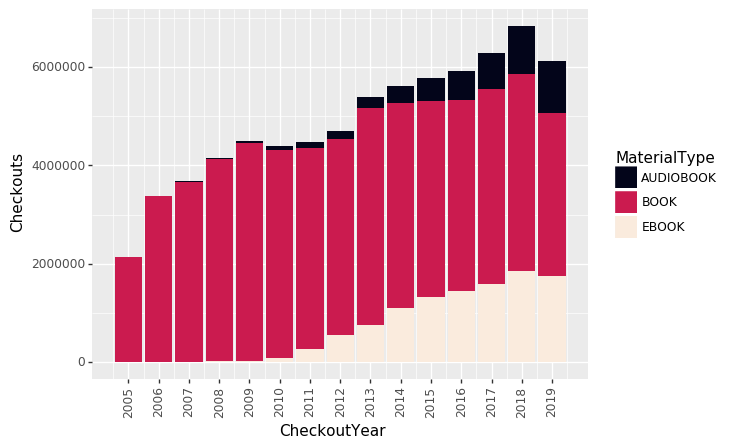

<ggplot: (8757870999473)>

In [11]:
g = (ggplot(df)
 + aes(x='CheckoutYear', y='Checkouts', fill='MaterialType')
 + geom_bar(stat='identity')
 + scale_x_continuous(breaks=range(2005,2020))
 + scale_fill_cmap_d('rocket')
 + theme(axis_text_x=element_text(rotation=90))
#  + scale_fill_brewer(type='qual', palette='Set3')
)

g

In [12]:
ggsave(g+t, height=10, width=10, filename=basepath+"type_year.png")

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/type_year.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


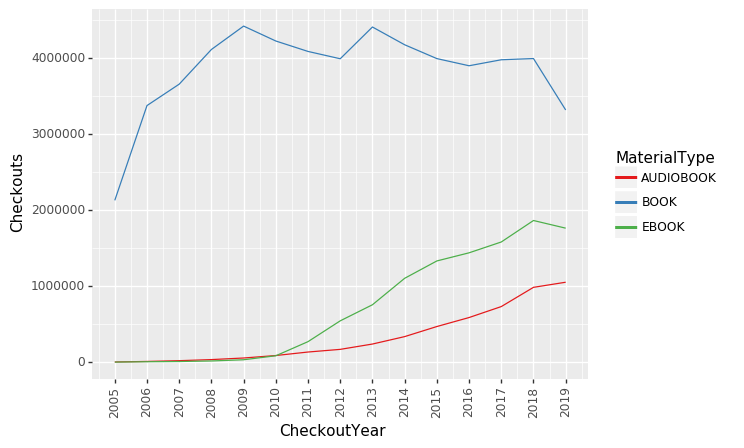

<ggplot: (8777505140905)>

In [25]:
g = (ggplot(df)
 + aes(x='CheckoutYear', y='Checkouts', color='MaterialType')
 + geom_path()
 + scale_x_continuous(breaks=range(2005,2020))
 + scale_color_cmap_d('Set1')
 + theme(axis_text_x=element_text(rotation=90))
#  + scale_fill_brewer(type='qual', palette='Set3')
)

g

In [26]:
ggsave(g + t, width=10, height=10, filename=basepath + 'compare_format.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/compare_format.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [4]:
df = (checkouts
      .groupby(['CheckoutYear','CheckoutMonth'])
      .agg({'Checkouts': 'sum'})
      .groupby(level=0, group_keys=False)
      .apply(lambda x : (x - x.mean())/x.std())
      .reset_index()
      .pivot(index='CheckoutYear', columns='CheckoutMonth', values='Checkouts')
     )

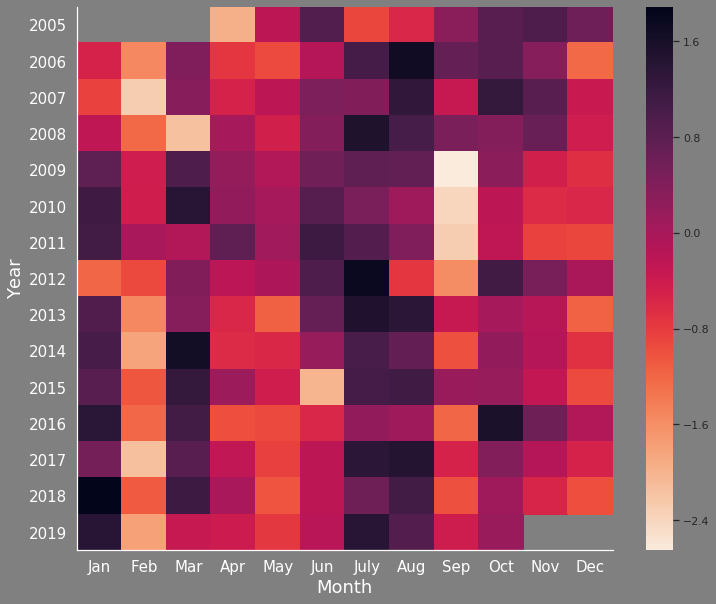

In [9]:
rcParams['figure.figsize'] = 12,10
rcParams['savefig.transparent'] = True
rcParams["legend.fontsize"] = 18
# rcParams["legend.textcolor"] = 'white'
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False})
# fig.patch.set_alpha(0.0) 
xtick_labs = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
# sns.set_style('darkgrid')
sns.axes_style({'font.color':'white', 'ytick.color':'white',
                        'ytick.label.color': 'white',
                       })
year_vs_month = sns.heatmap(df, cmap='rocket_r', xticklabels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                                             'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
# year_vs_month.set_xticks(ticks=)
year_vs_month.set_yticklabels(range(2005,2020), fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
year_vs_month.set_xticklabels(xtick_labs, fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
year_vs_month.set_ylabel("Year", fontdict={'color': 'white', 'fontsize': 18})
year_vs_month.set_xlabel("Month", fontdict={'color': 'white', 'fontsize': 18})
# year_vs_month.legend({'font.color':'white'})

fig = year_vs_month.get_figure()
fig.savefig('/home/rishi/Projects/Personal-Website/static/images/year_vs_month.png')
sns.despine()

In [22]:
df = (checkouts
      .groupby(['CheckoutYear','CheckoutMonth'])
      .agg({'Checkouts': 'sum'})
#       .groupby(level=0, group_keys=False)
#       .apply(lambda x : (x - x.mean())/x.std())
      .reset_index()
#       .pivot(index='CheckoutYear', columns='CheckoutMonth', values='Checkouts')
     )

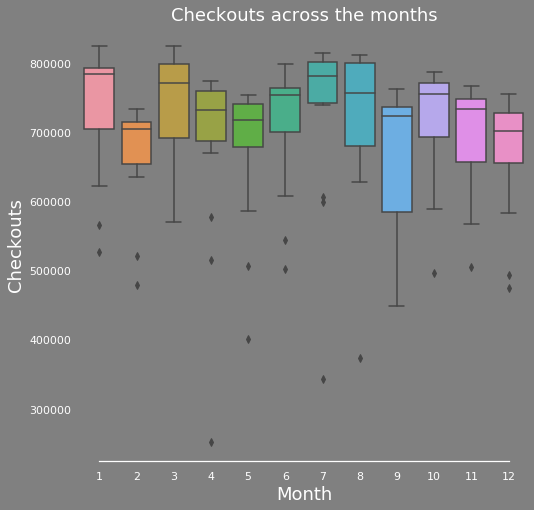

In [28]:
# sns.reset_defaults()
rcParams['figure.figsize'] = 8,8
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })
box_mat = sns.boxplot(x="CheckoutMonth", y="Checkouts",
            data=df)
# box_mat.set_yticklabels(range(30000,80000, 10000))
box_mat.set_ylabel("Checkouts", fontdict={'color': 'white', 'fontsize': 18})
box_mat.set_xlabel("Month", fontdict={'color': 'white', 'fontsize': 18})
box_mat.set_title("Checkouts across the months", fontdict={'color':'white', 'fontsize':18})
sns.despine(left=True, trim=True)
fig = box_mat.get_figure()
fig.savefig('/home/rishi/Projects/Personal-Website/static/images/checkouts_months.png')

In [40]:
cols = ['MaterialType', 'CheckoutYear','Checkouts', 'Subjects']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = (pd.DataFrame(chunk)
          .set_index('MaterialType')
          .loc[['BOOK', 'EBOOK', 'AUDIOBOOK'], ['CheckoutYear', 'Checkouts', 'Subjects']]
#           .dropna(subset=['Subjects'])
          .assign(Subjects = lambda x: x.Subjects.str.partition(',')[0])
         )
    
    checkout_dfs.append(df)

In [41]:
checkouts = pd.concat(checkout_dfs)

In [42]:
 df = (checkouts
       .groupby('Subjects', as_index = False)
       .agg({'Checkouts': 'sum'})
       .sort_values(by = 'Checkouts', ascending = False)
      )[:20]
df.Subjects = pd.Categorical(df.Subjects, df.Subjects)

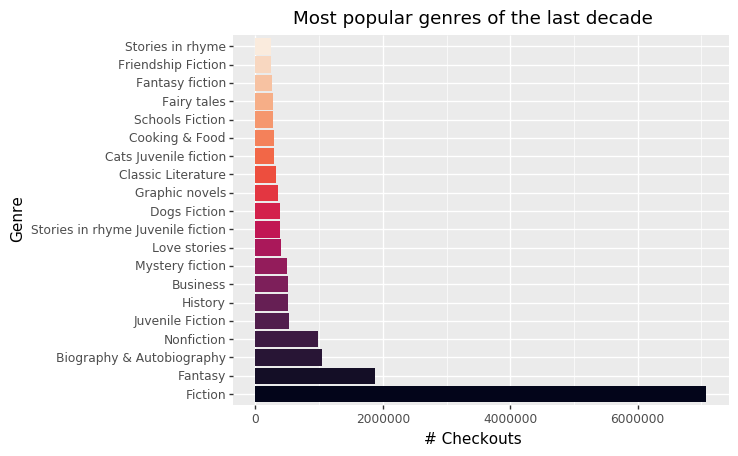

<ggplot: (8767915069265)>

In [43]:
g = (ggplot(df[:20])
 + aes(x='Subjects', y='Checkouts', fill='Subjects')
 + geom_bar(stat='identity', show_legend=False)
 + coord_flip()
 + scale_fill_cmap_d('rocket')
 + ggtitle(title="Most popular genres of the last decade")
 + labs(y='# Checkouts', x='Genre')
)
g

In [126]:
ggsave(g+t, width=10, height=10, filename=basepath + 'top_genres.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/top_genres.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


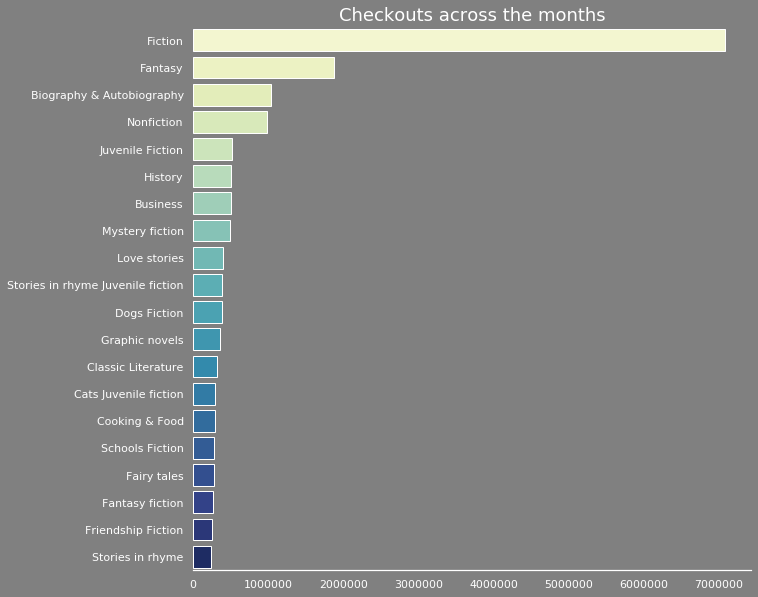

In [73]:
# sns.reset_defaults()
sns.set_context("paper")
rcParams['figure.figsize'] = 10,10
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })
box_subjects = sns.barplot(x="Checkouts", y="Subjects",data=df[:20], palette='YlGnBu')
box_subjects.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
box_subjects.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
# box_subjects.set_xtick(fontdict={'fontsize': 18 })
box_subjects.set_title("Checkouts across the months", fontdict={'color':'white', 'fontsize':18})
sns.despine(left=True)
fig = box_subjects.get_figure()
fig.savefig('/home/rishi/Projects/Personal-Website/static/images/top_genres.png', bbox_inches='tight')

In [20]:
top_subjs = checkouts.Subjects.value_counts()[:20]

In [21]:
df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'], as_index = False)
      .agg({'Checkouts': 'sum'})
     )

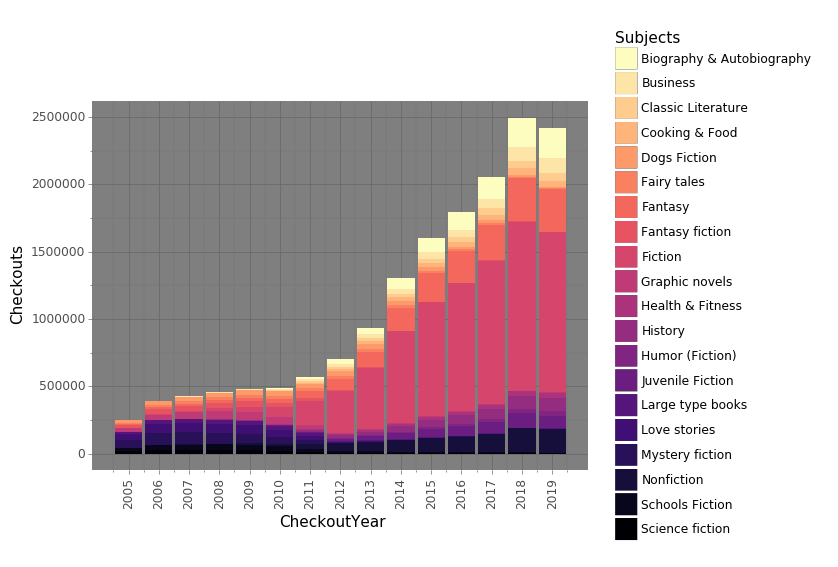

<ggplot: (8757647843725)>

In [22]:
g =(ggplot(df)
    + aes('CheckoutYear', 'Checkouts', fill='Subjects')
    + geom_bar(stat='identity')
    + theme_dark()
    + scale_fill_cmap_d('magma_r')
    + scale_x_continuous(breaks=range(2005,2020))
    + theme(axis_text_x=element_text(rotation=90))
   )
g

In [23]:
ggsave(g+t, width=10, height=10, filename=basepath+ 'subjects_year.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 10 x 10 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/subjects_year.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [127]:
def normalized(x):
    var = (x - x.mean())/x.std()
    return var

df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'])
      .agg({'Checkouts': 'sum'})
      .groupby('CheckoutYear')
      .transform(normalized)
      .reset_index()
      .pivot(index='Subjects', columns='CheckoutYear', values='Checkouts')
#       .groupby('CheckoutYear')
#       .transform({'Checkouts':normalized})
     )

In [128]:
df

,CheckoutYear,Subjects,Checkouts
0,2005,Biography & Autobiography,-0.735620
1,2005,Business,-0.731752
2,2005,Classic Literature,-0.722868
3,2005,Cooking & Food,-0.744020
4,2005,Dogs Fiction,0.292996
...,...,...,...
295,2019,Love stories,-0.454463
296,2019,Mystery fiction,-0.453887
297,2019,Nonfiction,0.206722
298,2019,Schools Fiction,-0.444420


Text(0.5, 1, 'Genres over the years')

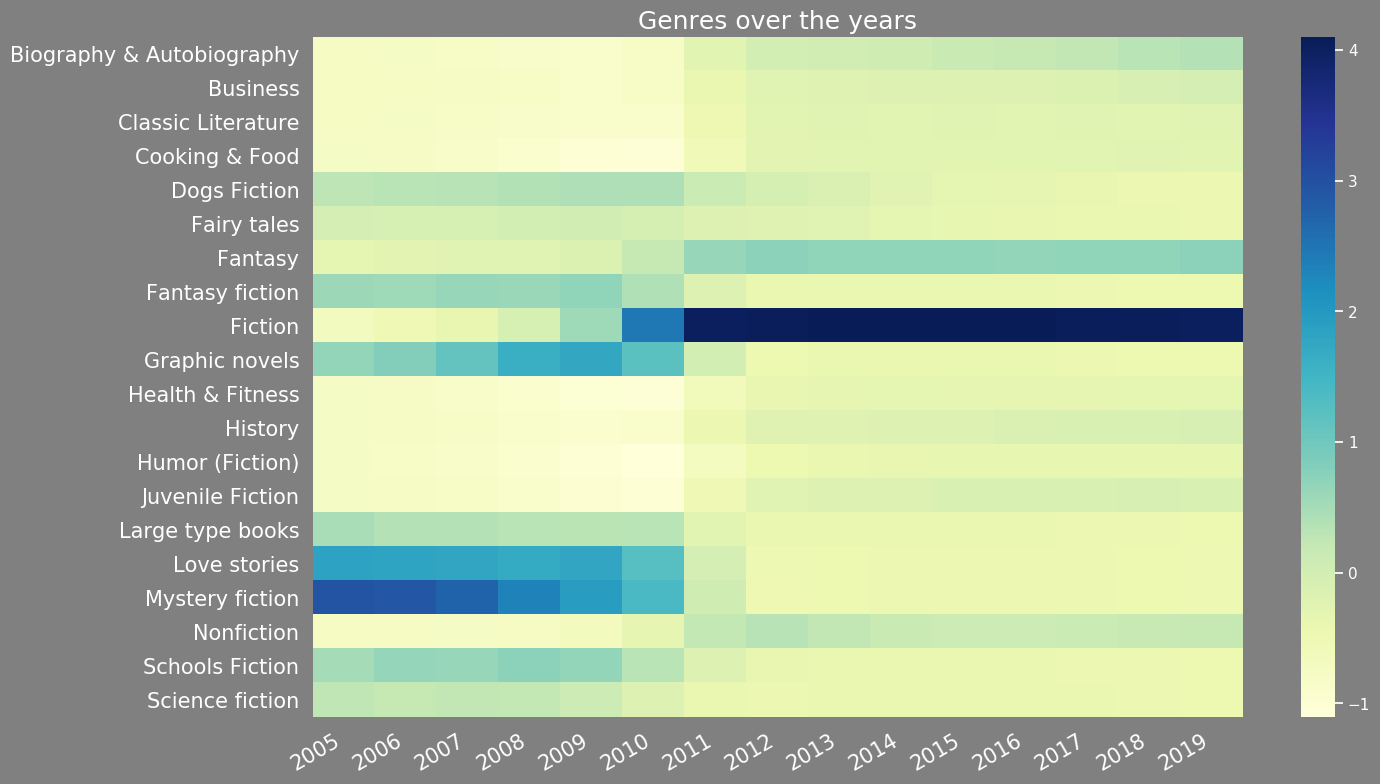

In [471]:
rcParams['figure.figsize'] = 15,10

genres = sns.heatmap(df, cmap='YlGnBu')
genres.set_yticklabels(df.index, fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
genres.set_xticklabels(range(2005,2020), fontdict={'fontsize':15, 'color': 'white'}, rotation="horizontal")
genres.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
genres.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
genres.get_figure().autofmt_xdate()
genres.set_title("Genres over the years", fontdict={'color':'white', 'fontsize':18})

In [478]:
genres.get_figure().savefig(basepath+"genre_years.png")

In [ ]:
def normalized(x):
    var = (x - x.mean())/x.std()
    return var

df = (checkouts[ checkouts.Subjects.isin(top_subjs.index)]
      .groupby(['CheckoutYear', 'Subjects'])
      .agg({'Checkouts': 'sum'})
      .groupby('CheckoutYear')
      .transform(normalized)
      .reset_index()
#       .pivot(index='Subjects', columns='CheckoutYear', values='Checkouts')
#       .groupby('CheckoutYear')
#       .transform({'Checkouts':normalized})
     )

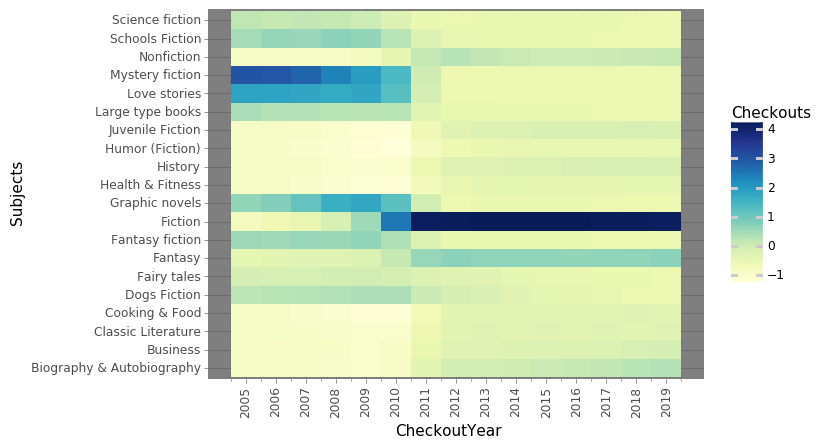

<ggplot: (8757863198649)>

In [134]:
g = (ggplot(df)
 + aes('CheckoutYear', 'Subjects', fill='Checkouts')
 + geom_tile()
 + scale_fill_cmap('YlGnBu')
 + theme_dark()
#  + scale_y_continuous(breaks=range(1,13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                                                   'July', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
 + scale_x_continuous(breaks=range(2005,2020))
 + theme(axis_text_x=element_text(rotation=90))
)
g

In [138]:
ggsave(g+t, width=15, height=15, filename=basepath+'genre_years.png')

/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 15 x 15 in image.
  from_inches(height, units), units), PlotnineWarning)
/home/rishi/.virtualenvs/pandas/lib/python3.7/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /home/rishi/Projects/Personal-Website/static/images/genre_years.png
  warn('Filename: {}'.format(filename), PlotnineWarning)


In [473]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[(df.CheckoutYear == 2018) | (df.CheckoutYear == 2019)]
#     df = (pd.DataFrame(chunk)
#           .set_index('CheckoutYear','MaterialType')
#           .loc[(['2010', '2019'], ['BOOK', 'EBOOK', 'AUDIOBOOK'])]
# #           .dropna(subset=['Subjects'])
#           .assign(Subjects = lambda x: x.Subjects.str.partition(',')[0])
#          )
    
    checkout_dfs.append(df)

In [474]:
checkouts = pd.concat(checkout_dfs)

In [475]:
df_2019 = (checkouts[checkouts.CheckoutYear == 2019]
           .assign(Title = lambda x: x.Title.str.partition('/')[0])
           .set_index('MaterialType')
           .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
           .reset_index()
          )

df_2019.Title = (df_2019.Title.str.strip().str.lower().str.partition('a memoir')[0].str.replace(':','')
.str.replace("\(unabridged\)", '').str.strip())

ranked = (df_2019
          .groupby('Title', as_index=False)
          .agg({'Checkouts': 'sum'})
          .set_index('Title')
         )

In [476]:
ranked.nlargest(20, 'Checkouts')

,Checkouts
Title,
becoming,18250
educated,13067
where the crawdads sing,12475
"crazy rich asians crazy rich asians series, book 1",6513
the library book,5937
the life-changing magic of tidying up the japanese art of decluttering and organizing,5000
you are a badass how to stop doubting your greatness and start living an awesome life,3991
little fires everywhere,3830
so you want to talk about race,3693


In [29]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('hunger games')
            | df.Title.str.lower().str.contains('catching fire')
            | df.Title.str.lower().str.contains('mockingjay') ]
    
    checkout_dfs.append(df)

In [30]:
checkouts = pd.concat(checkout_dfs)

checkouts.Title = checkouts.Title.str.lower().str.partition('/')[0].str.partition(':')[0].str.partition('[')[0].str.strip()

In [37]:
df = (checkouts
      [(checkouts.Title == 'the hunger games') | (checkouts.Title == 'catching fire') | (checkouts.Title == 'mockingjay')]
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .drop(columns=['Creator', 'Subjects', 'CheckoutMonth'])
      .dropna(subset=['MaterialType'])
      .set_index('MaterialType')
      .loc[['BOOK', 'AUDIOBOOK']]
      .reset_index()
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
     )

cols = ['the hunger games', 'catching fire', 'mockingjay']
df = df[cols]

In [38]:
df

Title,the hunger games,catching fire,mockingjay
Date,,,
2019-10-01,128.0,93.0,81.0
2019-09-01,124.0,87.0,68.0
2019-08-01,163.0,100.0,98.0
2019-07-01,136.0,95.0,86.0
2019-06-01,134.0,81.0,68.0
...,...,...,...
2009-01-01,63.0,0.0,0.0
2008-12-01,23.0,0.0,0.0
2008-11-01,22.0,0.0,0.0


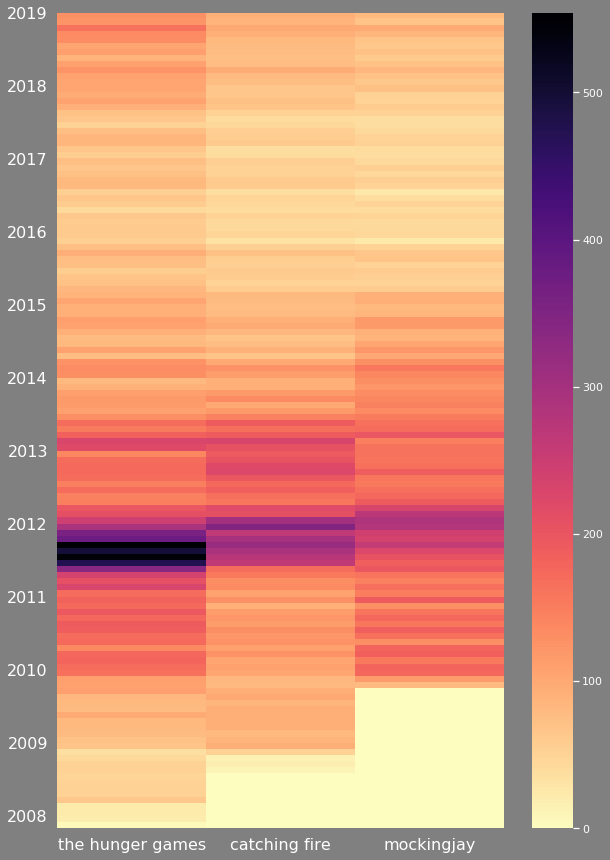

In [39]:
rcParams['figure.figsize'] = 10,15
rcParams['savefig.transparent'] = True
sns.set(rc={'axes.facecolor':'gray', 'figure.facecolor':'gray', 'axes.grid': False,
            'xtick.color': 'white', 'ytick.color': 'white', 'axes.spines.bottom': False
           })

g = sns.heatmap(df, cmap='magma_r',xticklabels=['the hunger games', 'catching fire', 'mockingjay'])
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})
loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2007, -1), fontdict={'fontsize':16})
g.set_xticklabels(cols, fontdict={'fontsize':16})
# g.legend(title="Checkouts")
g.yaxis.set_major_locator(loc)
fig = g.get_figure()
fig.savefig(basepath + 'hunger_games.png')

In [44]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Subjects', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('harry potter and the')]
    
    checkout_dfs.append(df)

In [45]:
checkouts = pd.concat(checkout_dfs)

checkouts .Title = (checkouts
                    .Title.str.lower().str.partition('/')[0]
                    .str.partition(':')[0].str.replace("'", '')
                    .str.partition('[')[0].str.strip()
                   )

In [46]:
def new_title(x):
    ret = ''
    if x.Title == 'harry potter and the sorcerers stone':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the chamber of secrets':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the prisoner of azkaban':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the goblet of fire':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the order of the phoenix':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the half-blood prince':
        ret = '1.' + x.Title
    if x.Title == 'harry potter and the deathly hallows':
        ret = '1.' + x.Title
    return ret

df = (checkouts
      [(checkouts.Title == 'harry potter and the sorcerers stone')
       | (checkouts.Title == 'harry potter and the chamber of secrets')
       | (checkouts.Title == 'harry potter and the prisoner of azkaban')
       | (checkouts.Title == 'harry potter and the goblet of fire')
       | (checkouts.Title == 'harry potter and the order of the phoenix')
       | (checkouts.Title == 'harry potter and the half-blood prince')
       | (checkouts.Title == 'harry potter and the deathly hallows')
      ]
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .dropna(subset=['MaterialType'])
      .set_index('MaterialType')
      .loc[['BOOK', 'EBOOK', 'AUDIOBOOK']]
      .reset_index()
      .drop(columns=['Creator', 'Subjects', 'CheckoutMonth'])
#       .reset_index()
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .sort_values(by='Checkouts')
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
      
     )

In [47]:
cols= ['harry potter and the sorcerers stone',
       'harry potter and the chamber of secrets',
       'harry potter and the prisoner of azkaban',
       'harry potter and the goblet of fire',
       'harry potter and the order of the phoenix',
       'harry potter and the half-blood prince',
       'harry potter and the deathly hallows']
df = df[cols]

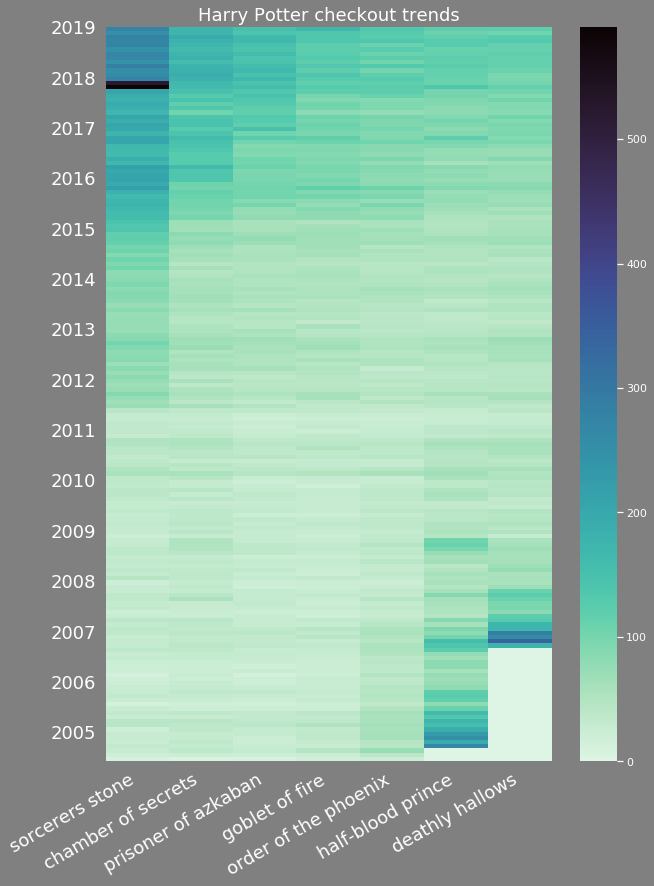

In [49]:
rcParams['figure.figsize'] = 10,15
cols2 = ['sorcerers stone',
       'chamber of secrets',
       'prisoner of azkaban',
       'goblet of fire',
       'order of the phoenix',
       'half-blood prince',
       'deathly hallows']
g = sns.heatmap(df, cmap='mako_r', xticklabels=cols)
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})

g.set_xticklabels(cols2, fontdict={'fontsize':18})
g.get_figure().autofmt_xdate()
loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2004, -1), fontdict={'fontsize': 18})
g.yaxis.set_major_locator(loc)
g.set_title("Harry Potter checkout trends", fontdict={'color':'white', 'fontsize':18})
fig = g.get_figure()
fig.savefig(basepath + 'hp.png')


In [50]:
cols = ['MaterialType', 'CheckoutMonth', 'CheckoutYear', 'Checkouts', 'Title', 'Creator']
pd_chunks = pd.read_csv('Checkouts_by_Title.csv', chunksize=500000, usecols=cols)

checkout_dfs = []

for chunk in pd_chunks:
    df = pd.DataFrame(chunk)
    df = df[df.Title.str.lower().str.contains('a song of ice and fire')]
    
    checkout_dfs.append(df)

In [51]:
checkouts = pd.concat(checkout_dfs)

checkouts.Title = checkouts.Title.str.lower().str.partition(':')[0].str.strip()

In [52]:
df = (checkouts
      .assign(Date =
              lambda x: pd.to_datetime(
                  checkouts.CheckoutYear.astype(str)
                  + '-'
                  + checkouts.CheckoutMonth.astype(str)
                  + '-'
                  + '01'
              )
             )
      .dropna(subset=['MaterialType'])
      .reset_index()
      .drop(columns=['Creator', 'CheckoutMonth'])
      .groupby(['Title','Date']).agg({'Checkouts': 'sum'}, as_index=False)
      .reset_index()
      .sort_values(by='Checkouts')
      .pivot(index='Date', columns='Title', values='Checkouts')
      .fillna(0)
      .sort_values(by='Date', ascending=False)
      
     )

In [53]:
checkouts.Title.unique()

array(['a storm of swords', 'a clash of kings', 'a dance with dragons',
       'a feast for crows', 'a game of thrones', 'beyond the wall',
       'clash of kings book two of a song of ice and fire'], dtype=object)

In [54]:
cols= ['a game of thrones',
       'a clash of kings',
       'a storm of swords',
       'a feast for crows',
       'a dance with dragons',
#        'beyond the wall'
      ]
df = df[cols]

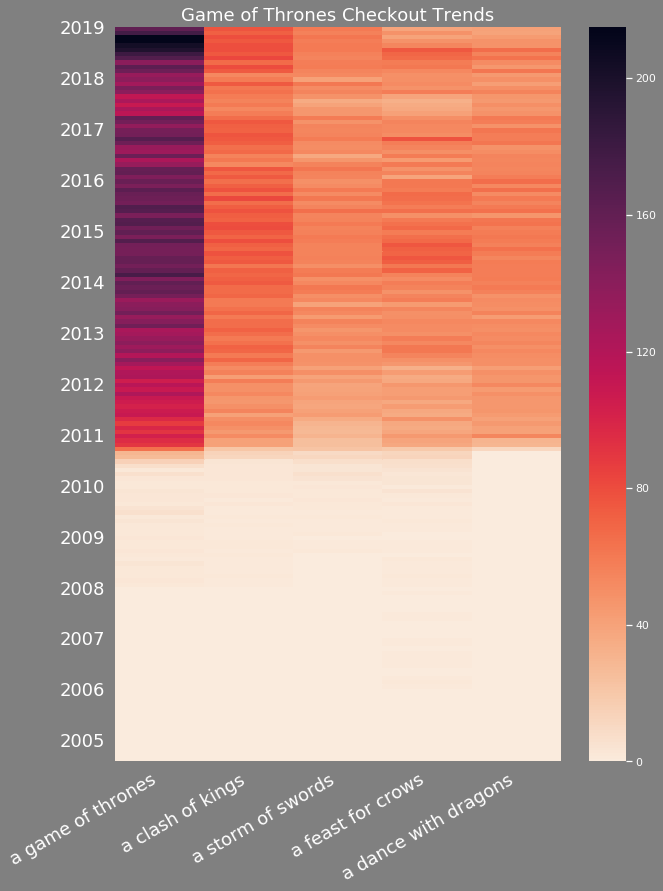

In [56]:
rcParams['figure.figsize'] = 10,15

g = sns.heatmap(df, cmap='rocket_r', xticklabels=cols)
g.set_ylabel("", fontdict={'color': 'white', 'fontsize': 18})
g.set_xlabel("", fontdict={'color': 'white', 'fontsize': 18})

g.set_xticklabels(cols, fontdict={'fontsize':18})
g.get_figure().autofmt_xdate()

loc = plticker.MultipleLocator(base=12) # this locator puts ticks at regular intervals
g.set_yticklabels(range(2020, 2004, -1), fontdict={'fontsize': 18})
g.yaxis.set_major_locator(loc)
g.set_title("Game of Thrones Checkout Trends", fontdict={'color':'white', 'fontsize':18})
fig = g.get_figure()
fig.savefig(basepath + 'got.png')
# g.annotate('a', xy=(10,pd.to_datetime('2016-12-31')), xytext=(10,pd.to_datetime('2016-12-31')))
# g.set_facecolor('xkcd:salmon')
